In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
from PIL import Image
import time

from datasets import Flickr8k_Images, Flickr8k_Features
from models import DecoderRNN, EncoderCNN ,DecoderLSTM
from utils import *
from config import *

In [2]:
# if false, train model; otherwise try loading model from checkpoint and evaluate
EVAL = False

decoderName = "LSTM"


# reconstruct the captions and vocab, just as in extract_features.py
lines = read_lines(TOKEN_FILE_TRAIN)
image_ids, cleaned_captions = parse_lines(lines)
vocab = build_vocab(cleaned_captions)


# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# initialize the models and set the learning parameters


decoderRNN = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, len(vocab), NUM_LAYERS).to(device)
decoderLSTM = DecoderLSTM(EMBED_SIZE, HIDDEN_SIZE, len(vocab), NUM_LAYERS).to(device)    
_temp_trainlossLSTM = []
_temp_trainlossRNN = []


In [ ]:
if not EVAL:

    # load the features saved from extract_features.py
    print(len(lines))
    features = torch.load('features30k.pt', map_location=device)
    print("Loaded features", features.shape)

    features = features.repeat_interleave(5, 0)
    print("Duplicated features", features.shape)

    dataset_train = Flickr8k_Features(
        image_ids=image_ids,
        captions=cleaned_captions,
        vocab=vocab,
        features=features,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=64, # change as needed
        shuffle=True,
        num_workers=0, # may need to set to 0
        collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
    )

    #start train decoder rnn-----------------------------------------
    
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(decoderRNN.parameters(), lr=LR)

#     optimizer = torch.optim.SGD(decoderRNN.parameters(), lr=LR)
  
    
    print(len(image_ids))
    print(len(cleaned_captions))
    print(features.shape)

    # TODO write training loop on decoder here

    # for each batch, prepare the targets using this torch.nn.utils.rnn function
   

    _temp_time = []
#     NUM_EPOCHS
    total_step = len(train_loader)
    for epoch in range(NUM_EPOCHS):
        before = time.time()
        running_loss = 0.0
        n = 0
        
        for i, (features, captions, lengths) in enumerate(train_loader):
            # Set mini-batch dataset
            if torch.cuda.is_available():
                features = features.cuda()
                captions = captions.cuda()
                
            
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            
            # Forward, Backward and Optimize
            decoderRNN.zero_grad()
            
            outputs = decoderRNN(features, captions, lengths)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            n += 1
            
            # Print log info
            if i % LOG_STEP == 0:
                c_time = (time.time()-before)
                print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f'
                      %(epoch+1, NUM_EPOCHS, i+1, total_step, 
                        loss.item())) 

        _temp_trainlossRNN.append(running_loss/n)
        _temp_time.append(c_time)
        print("decoderRNN: Epoch %d cost time: %.2f"%(epoch+1,c_time))
        
        
    # save model after training
    alltimeRNN = 0 
    for i in range(len(_temp_time)):
        alltimeRNN = alltimeRNN + _temp_time[i]
        print("Epoch %d cost time: %.2f s"%(i+1,_temp_time[i]))
    print("decoderRNN:The total time of  training the model is %.2f s"%(alltimeRNN))
    decoder_ckpt = torch.save(decoderRNN, "decoderRNN30k.ckpt")
    #end train decoder rnn-----------------------------------------

# if we already trained, and EVAL == True, reload saved model
else:

    data_transform = transforms.Compose([ 
        transforms.Resize(224),     
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                             (0.229, 0.224, 0.225))])


    test_lines = read_lines(TOKEN_FILE_TEST)
    test_image_ids, test_cleaned_captions = parse_lines(test_lines)
    test_image_ids = test_image_ids[::5]

    # load models
    encoder = EncoderCNN().to(device)
    decoder = torch.load("decoderRNN30k.ckpt").to(device)
    encoder.eval()
    decoder.eval() # generate caption, eval mode to not influence batchnor

In [3]:
EVAL = True

In [4]:
if not EVAL:

    # load the features saved from extract_features.py
    print(len(lines))
    features = torch.load('features30k.pt', map_location=device)
    print("Loaded features", features.shape)

    features = features.repeat_interleave(5, 0)
    print("Duplicated features", features.shape)

    dataset_train = Flickr8k_Features(
        image_ids=image_ids,
        captions=cleaned_captions,
        vocab=vocab,
        features=features,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=64, # change as needed
        shuffle=True,
        num_workers=0, # may need to set to 0
        collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
    )

    #start train decoder lstm-----------------------------------------
    
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(decoderLSTM.parameters(), lr=LR)  

#     optimizer = torch.optim.SGD(decoderLSTM.parameters(), lr=LR)
    
    _temp_time = []
#     NUM_EPOCHS
    total_step = len(train_loader)
    for epoch in range(NUM_EPOCHS):
        before = time.time()
        running_loss = 0.0
        n = 0
        
        for i, (features, captions, lengths) in enumerate(train_loader):
            # Set mini-batch dataset
            if torch.cuda.is_available():
                features = features.cuda()
                captions = captions.cuda()
                
            
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            
            # Forward, Backward and Optimize
            decoderLSTM.zero_grad()
            
            outputs = decoderLSTM(features, captions, lengths)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            n += 1
            
            # Print log info
            if i % LOG_STEP == 0:
                c_time = (time.time()-before)
                print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f'
                      %(epoch+1, NUM_EPOCHS, i+1, total_step, 
                        loss.item())) 

        _temp_trainlossLSTM.append(running_loss/n)
        _temp_time.append(c_time)
        print("decoderLSTM:Epoch %d cost time: %.2f"%(epoch+1,c_time))
        
        
    # save model after training
    alltimeLSTM = 0 
    for i in range(len(_temp_time)):
        alltimeLSTM = alltimeLSTM + _temp_time[i]
        print("Epoch %d cost time: %.2f s"%(i+1,_temp_time[i]))
    print("decoderLSTM: The total time of  training the model is %.2f s"%(alltimeLSTM))
    decoder_ckpt = torch.save(decoderLSTM, "decoderlstm30k.ckpt")
    #end train decoder lstm-----------------------------------------

# if we already trained, and EVAL == True, reload saved model
else:

    data_transform = transforms.Compose([ 
        transforms.Resize(224),     
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                             (0.229, 0.224, 0.225))])


    test_lines = read_lines(TOKEN_FILE_TEST)
    test_image_ids, test_cleaned_captions = parse_lines(test_lines)
    test_image_ids = test_image_ids[::5]

    # load models
    encoder = EncoderCNN().to(device)
    decoder = torch.load("decoderlstm30k.ckpt").to(device)
    encoder.eval()
    decoder.eval() # generate caption, eval mode to not influence batchnor

In [ ]:

fig, ax1 = plt.subplots()
plt.plot(_temp_trainlossLSTM, 'g', label = 'decoderLSTM cost %.2f s'%(alltimeLSTM))
plt.legend(loc='center')
plt.xlabel("epoch(10)")
plt.ylabel('loss')
plt.title('Training loss with Adam(Flicker30k_Dataset)')
plt.legend(loc='upper left')
plt.savefig("Training loss with Adam(Flicker30k_Dataset).png")
plt.show()


In [ ]:
fig, ax1 = plt.subplots()
plt.plot(_temp_trainlossRNN, 'r', label = 'decoderRNN cost %.2f s'%(alltimeRNN))
plt.plot(_temp_trainlossLSTM, 'g', label = 'decoderLSTM cost %.2f s'%(alltimeLSTM))
plt.legend(loc='center')
plt.xlabel("epoch(10)")
plt.ylabel('loss')
plt.title('Training loss with SGD')
plt.legend(loc='upper left')
plt.savefig("Train with SGD.png")
plt.show()

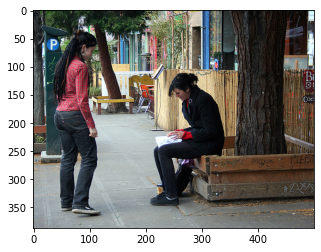

<start> a man and a woman are sitting on a bench <end>
['a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench']


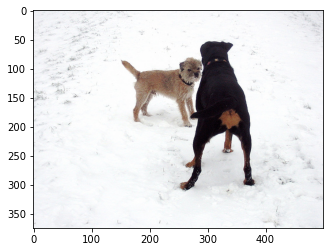

('<start> two dogs are running through the snow <end>', ['two', 'dogs', 'are', 'running', 'through', 'the', 'snow'])


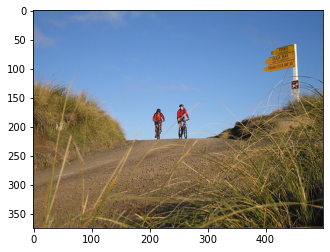

('<start> two children are riding bicycles on a sandy beach <end>', ['two', 'children', 'are', 'riding', 'bicycles', 'on', 'a', 'sandy', 'beach'])


In [5]:
image1 = Image.open("Flicker8k_Dataset/Flicker8k_Images/397451339_76a84bd310.jpg")
feature1 = encoder(data_transform(image1).to(device).unsqueeze(0)).to(device)
sampled_ids1 = decoder.sample(feature1).squeeze().cpu().data.numpy()
predicted_caption1,v = decode_caption(sampled_ids1, vocab) 
plt.imshow(image1)
plt.show()
print(predicted_caption1)
print(v)

image2 = Image.open("Flicker8k_Dataset/Flicker8k_Images/386656845_4e77c3e3da.jpg")
feature2 = encoder(data_transform(image2).to(device).unsqueeze(0)).to(device)
sampled_ids2 = decoder.sample(feature2).squeeze().cpu().data.numpy()
predicted_caption2 = decode_caption(sampled_ids2, vocab) 
plt.imshow(image2)
plt.show()
print(predicted_caption2)


image3 = Image.open("Flicker8k_Dataset/Flicker8k_Images/384465370_9918873f9a.jpg")
feature3 = encoder(data_transform(image3).to(device).unsqueeze(0)).to(device)
sampled_ids3 = decoder.sample(feature3).squeeze().cpu().data.numpy()
plt.imshow(image3)
plt.show()
predicted_caption3 = decode_caption(sampled_ids3, vocab) 



print(predicted_caption3)





In [6]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
smooth = SmoothingFunction()
collect_words = [] 
collect_words_all =[]
for i,str1 in enumerate(test_cleaned_captions):
    collect_words.append(str1.split(" "))
    
for i in range(0,len(collect_words),5):
    str2=collect_words[i:i+5]
    collect_words_all.append(str2)
    
#define 1-gram,2-gram,3-gram,4-gram
score1 = 0
score2 = 0
score3 = 0
score4 = 0

for i,image_id in enumerate(test_image_ids): 
    path = IMAGE_DIR + str(image_id) + ".jpg"
    image = Image.open(open(path, 'rb'))
    feature = encoder(data_transform(image).to(device).unsqueeze(0)).to(device)
    sampled_ids = decoder.sample(feature).squeeze().cpu().data.numpy()
#     print(sampled_ids)
    predicted_caption,predicted_spiltcaption = decode_caption(sampled_ids, vocab) 
#     print(predicted_spiltcaption)
    reference = collect_words_all[i]
    candidate = predicted_spiltcaption 
    #use 1 to 4 gram to show the score
    _gram1_score = sentence_bleu(reference,candidate,weights=(1, 0, 0, 0),smoothing_function=smooth.method1)
    _gram2_score = sentence_bleu(reference,candidate,weights=(0.5, 0.5, 0, 0),smoothing_function=smooth.method1)
    _gram3_score = sentence_bleu(reference,candidate,weights=(0.33, 0.33, 0.33, 0),smoothing_function=smooth.method1)
    _gram4_score = sentence_bleu(reference,candidate,weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smooth.method1)
    avg_score = (_gram1_score+_gram2_score+_gram3_score+_gram4_score)/4
    
#     if(avg_score>0.1 and avg_score<0.2  ):
    if(image_id =='380590140_25b9889772'or image_id =='478750151_e0adb5030a' ):            
        print("image_id is %s"%image_id)
        print("bleu__average_socre is %f"%avg_score)
        print(predicted_caption)
        print(reference)
        plt.imshow(image)
        plt.show()
    


    if(image_id =='458735196_176e7df6b3' or  image_id == '708860480_1a956ae0f7'):            
        print("image_id is %s"%image_id)
        a_so  = (_gram1_score+_gram2_score)/2
        print("bleu__average_socre is %f"%a_so)
        print(predicted_caption)
        print(reference)
        plt.imshow(image)
        plt.show()
     
    
    
    
    score1 = score1 + _gram1_score
    score2 = score2 + _gram2_score
    score3 = score3 + _gram3_score
    score4 = score4 + _gram4_score
av_score1 = score1/len(test_image_ids)
av_score2 = score2/len(test_image_ids)
av_score3 = score3/len(test_image_ids)
av_score4 = score4/len(test_image_ids)

print('1-gram average score:%f'\
      %av_score1)
print('2-gram average score:%f'\
      %av_score2)
print('3-gram average score:%f'\
      %av_score3)
print('4-gram average score:%f'\
      %av_score4)


print("all test set average scores:")
print((av_score1+av_score2)/2)  


1-gram average score:0.523108
2-gram average score:0.316834
3-gram average score:0.189133
4-gram average score:0.119767
all test set average scores:
0.4199708377614424


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

#USE nn.Embedding
embedding = nn.Embedding(len(vocab), EMBED_SIZE)

#define cosine_similarity tensor
avref_cosine_similarity = torch.zeros((2,2))
rescale_avref_cosine_similarity = torch.zeros((2,2))

for i,image_id in enumerate(test_image_ids): 
    path = IMAGE_DIR + str(image_id) + ".jpg"
    image = Image.open(open(path, 'rb'))
    feature = encoder(data_transform(image).to(device).unsqueeze(0)).to(device)
    sampled_ids = decoder.sample(feature).squeeze().cpu().data.numpy()
    predicted_caption,predicted_spiltcaption = decode_caption(sampled_ids, vocab) 
    w_embedding = torch.tensor(0)
    avpre_embedding = torch.tensor(0)
    for word in predicted_spiltcaption:
        lookup_tensor = torch.tensor([vocab.word2idx[word]], dtype=torch.long)
        w_embedding = w_embedding + embedding(lookup_tensor)
    avpre_embedding =  w_embedding/len(predicted_spiltcaption)
    reference = collect_words_all[i]
    
    avref_embedding = torch.tensor(0)
    ref_cosine_similarity = torch.tensor(0)
    
    #Define a scaled cosine similarity in order to compare bleu
    rescale_ref_cosine_similarity = torch.tensor(0)
    
    for sent in reference:
        w_embedding = torch.tensor(0)
        for word in sent:
            if word  not in vocab.word2idx:
                word = '<unk>'
            lookup_tensor = torch.tensor([vocab.word2idx[word]], dtype=torch.long)
            w_embedding = w_embedding + embedding(lookup_tensor)
        avref_embedding =     w_embedding/len(sent)
        each_ref_cosine_similarity = cosine_similarity(torch.cat((avref_embedding,avpre_embedding),0).detach().numpy())
        
        
        #rescale the cosine similarity
        if(each_ref_cosine_similarity[0][1] < 0 ):
            rescale_each_ref_cosine_similarity = (each_ref_cosine_similarity +1 )/2
        else:
            rescale_each_ref_cosine_similarity = each_ref_cosine_similarity
#         print(each_ref_cosine_similarity)
   
        ref_cosine_similarity = ref_cosine_similarity + each_ref_cosine_similarity
    
        rescale_ref_cosine_similarity = rescale_ref_cosine_similarity + rescale_each_ref_cosine_similarity

    ref_cosine_similarity = ref_cosine_similarity/5
    rescale_ref_cosine_similarity = rescale_ref_cosine_similarity/5
    
    if(image_id =='708860480_1a956ae0f7'or image_id =='377872672_d499aae449' ):         
        print("image_id is %s"%image_id)
        print("cosine_similarity_average_socre is : %f"%ref_cosine_similarity[0][1].item())
        print(predicted_caption)
        print(reference)
        plt.imshow(image)
        plt.show()
            

    if(image_id =='458735196_176e7df6b3'): 
        print("image_id is %s"%image_id)
        print("cosine_similarity_average_socre is : %f"%ref_cosine_similarity[0][1].item())
        print(predicted_caption)
        print(reference)
        plt.imshow(image)
        plt.show()
    
    
    
    avref_cosine_similarity += ref_cosine_similarity
    rescale_avref_cosine_similarity+= rescale_ref_cosine_similarity
#     print(avref_cosine_similarity)
print("all test set average scores:")
print(avref_cosine_similarity/len(test_image_ids))  

print("rescale all test set average scores:")
print(rescale_avref_cosine_similarity/len(test_image_ids)) 

all test set average scores:
tensor([[1.0000, 0.3804],
        [0.3804, 1.0000]])
rescale all test set average scores:
tensor([[1.0000, 0.3914],
        [0.3914, 1.0000]])
